Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import mplcursors
import os
import plotly.express as px
import plotly.io as pio
from pathlib import Path

In [3]:
try:
    base_dir = Path(__file__).resolve().parent.parent
except NameError:
    base_dir = Path().resolve()

1. Load data

In [10]:
file_path = base_dir / "data" / "final" / "1_cleaned_ingredients.xlsx"
df = pd.read_excel(file_path, engine="openpyxl")

3. Bar plots - provides a frequency distribution of food products across three key attributes: Eco-Grade, Nova Group, and Nutri-Score. Each plot presents the count of products for each category within these attributes, with percentage labels for clearer insight. This visualisation enables easy comparison across categories to identify the distribution of food products according to Eco-Grade, Nova Group, and Nutri-Score, facilitating an understanding of how products are distributed based on their environmental impact, level of processing, and healthiness.

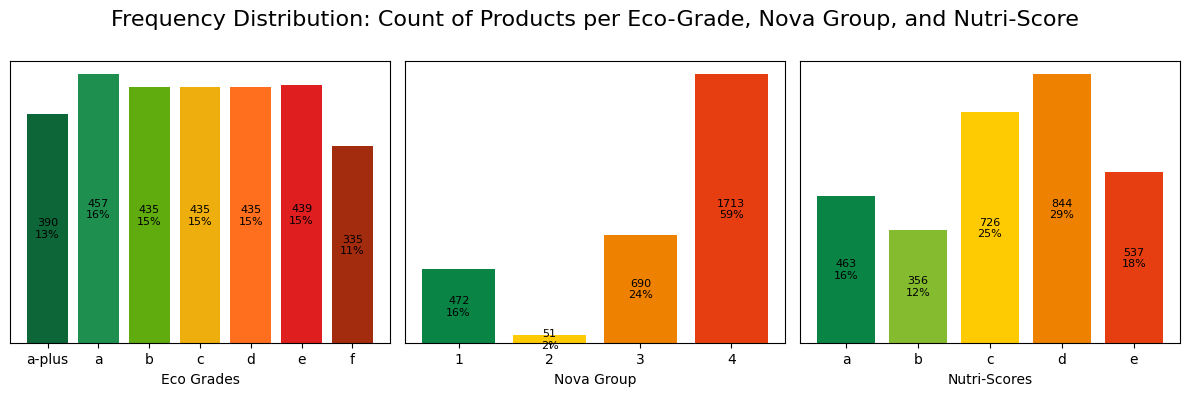

In [11]:
# Remove y-axis labels and ticks
def remove_y_axis(ax):
    ax.set_ylabel("")
    ax.set_yticklabels([])
    ax.tick_params(axis="y", left=False)
    ax.grid(False)

# Bar plot
def plot_bar(ax, data, categories, colours, xlabel):
    counts = data.value_counts().reindex(categories).fillna(0).astype(int)
    total = counts.sum()
    bars = ax.bar(categories, counts.values, color=colours)
    ax.set_xlabel(xlabel)
    remove_y_axis(ax)
    for bar, value in zip(bars, counts.values):
        pct = (value / total) * 100 if total > 0 else 0
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() / 2,
            f"{value}\n{round(pct)}%",
            ha="center",
            va="center",
            fontsize=8,
        )
    return bars


# Specialised plot for NOVA groups
def plot_nova_group(ax, data, colours, xlabel):
    counts = data.value_counts().sort_index()
    total = counts.sum()
    bars = ax.bar(counts.index.astype(str), counts.values, color=colours)
    ax.set_xlabel(xlabel)
    remove_y_axis(ax)
    for bar, value in zip(bars, counts.values):
        pct = (value / total) * 100 if total > 0 else 0
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() / 2,
            f"{value}\n{round(pct)}%",
            ha="center",
            va="center",
            fontsize=8,
        )
    return bars


# --- Plotting Section ---
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Eco Grades - specific order and colours
eco_order = ["a-plus", "a", "b", "c", "d", "e", "f"]
eco_colours = [
    "#0c6637",
    "#1f8f4f",
    "#60ac0e",
    "#eeae0e",
    "#ff6f1e",
    "#df1f1f",
    "#a32c0f",
]
plot_bar(axes[0], df["ecoscore_grade"], eco_order, eco_colours, "Eco Grades")

# NOVA Groups - specific colours
nova_colours = ["#098445", "#fecb02", "#ee8100", "#e63e11"]
plot_nova_group(axes[1], df["nova_group"], nova_colours, "Nova Group")

# Nutri Scores - specific colours
nutri_order = sorted(df["nutriscore_grade"].dropna().unique())
nutri_colours = ["#098445", "#85bb2f", "#fecb02", "#ee8100", "#e63e11"]
plot_bar(axes[2], df["nutriscore_grade"], nutri_order, nutri_colours, "Nutri-Scores")

# Final layout
plt.suptitle(
    "Frequency Distribution: Count of Products per Eco-Grade, Nova Group, and Nutri-Score",
    fontsize=16,
)
plt.tight_layout()
plt.subplots_adjust(top=0.85)

# Saving the plot to the 'figures' folder
output_dir = base_dir / "reports" / "figures"
output_dir.mkdir(parents=True, exist_ok=True)
output_path = output_dir / "distribution_plot.png"
plt.savefig(output_path, bbox_inches="tight")

# Show visual
plt.show()

2. Bubble chart - provides a visual comparison of food products across different Nutri-Scores, Nova Groups, and Eco-Grades. The chart is organised into subplots for each unique Eco-Grade, where the x-axis represents Nutri-Score categories and the y-axis represents Nova Group categories. The chart enables an intuitive and detailed exploration of the intersection between health ratings (Nutri-Score), food processing levels (Nova Group), and environmental impact (Eco-Grade), helping me to identify patterns and trends in the dataset.

C:\Users\megan\AppData\Local\Temp\ipykernel_7440\1283798410.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("RdYlGn_r")


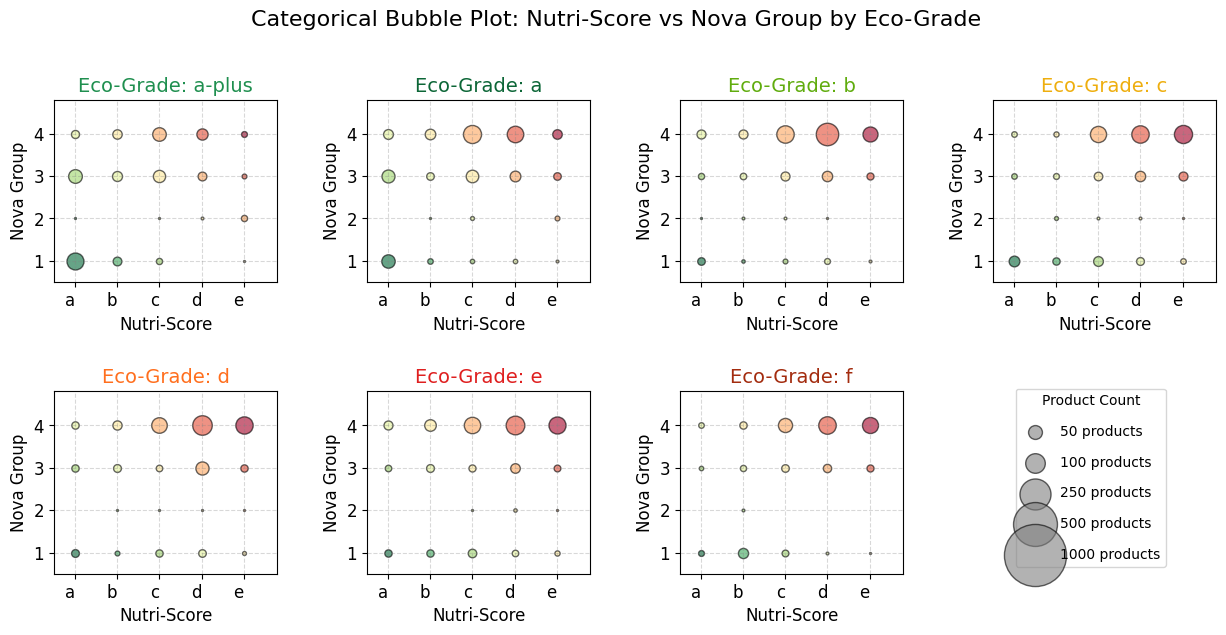

In [12]:
# Count and reshape the data
counts = (
    df.groupby(["nova_group", "nutriscore_grade", "ecoscore_grade"])
    .size()
    .reset_index(name="Count")
)
eco_grades = counts["ecoscore_grade"].unique()

# Reorder eco_grades so "A-Plus" comes first
eco_grades = ["a-plus"] + [grade for grade in eco_grades if grade != "a-plus"]

# Create a custom colourmap
cmap = plt.cm.get_cmap("RdYlGn_r")

# Eco-grade colours from original heatmap code
eco_colors = [
    "#0c6637",
    "#1f8f4f",
    "#60ac0e",
    "#eeae0e",
    "#ff6f1e",
    "#df1f1f",
    "#a32c0f",
]

# Adjust the number of rows and columns for the subplots
nrows = 2
ncols = int(np.ceil(len(eco_grades) / nrows))

# Create a figure with 6 sublots and sharey=False to avoid shared y-axis
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 6), sharey=False)

# Flatten axes for easier iteration (this handles the case when the grid is not perfectly square)
axes = axes.flatten()

# Create a list of Nutri-Scores and Nova Groups to help with assigning the colours
nutri_scores = counts["nutriscore_grade"].unique()
nova_groups = counts["nova_group"].unique()

# Normalise the combinations of Nutri-Score and Nova Group into a 2D grid for colouring
color_mapping = {}
for i, nutri_score in enumerate(nutri_scores):
    for j, nova_group in enumerate(nova_groups):
        color_mapping[(nutri_score, nova_group)] = (i + j) / (
            len(nutri_scores) + len(nova_groups) - 2
        )

# Loop through each Eco-Grade and plot
for i, eco_grade in enumerate(eco_grades):
    eco_data = counts[counts["ecoscore_grade"] == eco_grade]

    # Create a bubble plot
    ax = axes[i]
    eco_grade_idx = list(counts["ecoscore_grade"].unique()).index(eco_grade)
    eco_color = eco_colors[eco_grade_idx]

    # Set the title with the eco-grade colour
    ax.set_title(f"Eco-Grade: {eco_grade}", fontsize=14, color=eco_color)

    bubbles = []
    tooltip_texts = []

    # Create the bubbles
    for _, row in eco_data.iterrows():
        nova_group = row["nova_group"]
        nutri_score = row["nutriscore_grade"]
        count = row["Count"]

        # Determine position of the bubble (x = Nutri-Score, y = Nova Group)
        x_pos = np.where(nutri_scores == nutri_score)[0][0]
        y_pos = np.where(nova_groups == nova_group)[0][0]

        # Bubble size (scaled by count)
        size = count * 2

        # Get colour based on the combination of Nutri-Score and Nova Group
        combination_value = color_mapping[(nutri_score, nova_group)]
        color = cmap(combination_value)

        # Plot the bubble
        bubble = ax.scatter(
            x_pos, y_pos, s=size, c=[color], alpha=0.6, edgecolors="black"
        )

    # Combine all scatter plots into one cursor group
    cursor = mplcursors.cursor(bubbles, hover=True)

    # Set axis labels for each subplot
    ax.set_xticks(np.arange(len(nutri_scores)))
    ax.set_xticklabels(nutri_scores, rotation=0, ha="right", fontsize=12)
    ax.set_yticks(np.arange(len(nova_groups)))
    ax.set_yticklabels(nova_groups, fontsize=12)

    # Set y-axis label for each subplot
    ax.set_ylabel("Nova Group", fontsize=12)

    # Set x-axis label for all subplots
    ax.set_xlabel("Nutri-Score", fontsize=12)

    # Add faint grey grid lines
    ax.grid(True, color="grey", linestyle="--", alpha=0.3)

    # Dynamically set axis limits so bubbles are visible
    ax.set_ylim(-0.5, len(nova_groups) - 0.20)
    ax.set_xlim(-0.5, len(nutri_scores) - 0.20)

# Hide any remaining empty subplots (axes without any eco_grade)
for i in range(len(eco_grades), len(axes)):
    axes[i].axis("off")  # Hide the axis

# Creating legend
# Define representative sizes for the legend (adjust as needed)
size_counts = [50, 100, 250, 500, 1000]
size_scaling = 2

# Create legend handles for these sizes
size_handles = [
    plt.scatter(
        [],
        [],
        s=count * size_scaling,
        edgecolors="black",
        facecolors="gray",
        alpha=0.6,
        label=f"{count} products",
    )
    for count in size_counts
]

# Get the position of the last subplot in the first row
last_ax = axes[ncols - 1]
box = last_ax.get_position()

# Manually place the legend just below this subplot
fig.legend(
    handles=size_handles,
    title="Product Count",
    loc="upper left",
    bbox_to_anchor=(box.x0 - -0.03, box.y0 - 0.10),  # Adjust y offset as needed
    frameon=True,
    labelspacing=1.2,
)

# Adjust layout and add title
plt.subplots_adjust(top=0.90, wspace=0.4, hspace=0.6)
plt.suptitle(
    "Categorical Bubble Plot: Nutri-Score vs Nova Group by Eco-Grade",
    fontsize=16,
    y=1.05,
)

# Saving the plot to the 'figures' folder
output_dir = base_dir / "reports" / "figures"
output_dir.mkdir(parents=True, exist_ok=True)
output_path = output_dir / "bubble_plot.png"
plt.savefig(output_path, bbox_inches="tight")

# Show visual
plt.show()

3. Treemap - provides the distribution of food products across various food groups and subgroups. The size of each section corresponds to the number of products in that group or subgroup, and hovering over each section reveals the exact count of products in that category.
This enables me to understand the composition of food categories in the dataset.

In [ ]:
# Create a column to use as a count
df["count"] = 1

# Create treemap with tooltip
fig = px.treemap(
    df,
    path=["food_group", "food_subgroup"],
    values="count",
    color_discrete_sequence=px.colors.qualitative.Pastel1,
    custom_data=["count", "food_group", "food_subgroup"],
)

# Tooltip
fig.update_traces(
    hovertemplate="<b>Food Group</b>: %{customdata[1]}<br>"
    + "<b>Food Subgroup</b>: %{customdata[2]}<br>"
    + "<b>No. of Products</b>: %{customdata[0]}<extra></extra>"
)

# Title and padding adjustment
fig.update_layout(
    title={
        "text": "Treemap: Food Products by Food Group and Food Subgroup <br> (Interactive - Hover to See Values)",
        "x": 0.5,
        "xanchor": "center",
        "yanchor": "top",
    },
    font=dict(size=16),
    font_color="black",
    margin=dict(t=50, b=20, l=20, r=20),
)

# Saving the plot to the 'figures' folder
output_path = os.path.join(output_dir, "treemap_plot.svg")
pio.write_image(fig, output_path, engine="kaleido", format="svg", width=800, height=600)

# Show the plot
fig.show()

**References**

https://www.geeksforgeeks.org/adding-value-labels-on-a-matplotlib-bar-chart/

https://www.geeksforgeeks.org/plotting-multiple-bar-charts-using-matplotlib-in-python/

https://stackoverflow.com/questions/66294835/categorical-bubble-plot-in-python

https://stackoverflow.com/questions/28931224/how-to-add-value-labels-on-a-bar-chart 

https://plotly.com/python/figure-labels/